In [1]:
import numpy as np
import scipy.spatial.distance as distance
import scipy.stats as stats
import matplotlib.pyplot as plt
import keras as K
import tensorflow as tf

Using TensorFlow backend.


In [2]:
from keras.datasets import mnist

In [3]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.initializers import RandomNormal

In [46]:
class encoder_network():
    def __init__(self,sess,n_parts, input_dim, output_dim, n_hidden =400,rate = 0.3, mu = 0, sigma = 1):
        self.n_parts = n_parts
        self.n_hidden = n_hidden
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.rate = rate
        self.mu = mu
        self.sigma = sigma
        
        self.sess = sess
        
        self.phi = tf.placeholder(tf.float32,shape=(n_parts,self.output_dim))
        self.model = self.build_network()
        self.eta_grad = tf.gradients(tf.stop_gradient(self.phi)*self.model.output,self.model.trainable_weights)
    
        self.sess.run(tf.global_variables_initializer())
        
    def build_network(self):
        encoder_inputs = Input(batch_shape=(self.n_parts,self.input_dim,))
        encoder_drop   = Dropout(self.rate)(encoder_inputs)
        encoder_hidden = Dense(self.n_hidden, activation='tanh',
                               kernel_initializer = RandomNormal(self.mu,self.sigma),
                               bias_initializer = RandomNormal(self.mu,self.sigma))(encoder_drop)
        encoder_hidden = Dropout(self.rate)(encoder_hidden)
        encoder_output = Dense(self.output_dim,
                               kernel_initializer = RandomNormal(self.mu,self.sigma),
                               bias_initializer = RandomNormal(self.mu,self.sigma))(encoder_hidden)
        encoder = Model(inputs = encoder_inputs, outputs = encoder_output)
        
        return encoder
            
    def eval_eta_grad(self,x_in,phi):
        return self.sess.run(self.eta_grad, feed_dict={self.model.input : x_in,self.phi : phi})

In [47]:
class decoder_network():
    def __init__(self,sess,n_parts,input_dim,output_dim,n_hidden = 400,rate = 0.3, mu = 0, sigma = 1):
        self.n_parts = n_parts
        self.n_hidden = n_hidden
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.rate = rate
        self.mu = mu
        self.sigma = sigma
        
        self.sess = sess
        
        self.model = self.build_network()
        
        self.x_real = tf.placeholder(tf.float32, shape=(self.output_dim,))
        self.logpxz = self.eval_logpxz(self.x_real, self.model.output)
        
        self.theta_grad = tf.gradients(self.logpxz, self.model.trainable_weights)
        self.z_grad = tf.gradients(self.logpxz, self.model.input)
        
        self.sess.run(tf.global_variables_initializer())
        
    def build_network(self):
        decoder_inputs = Input(batch_shape=(None, self.input_dim))
        #decoder_inputs = Dropout(self.rate,input_shape=(None, self.input_dim))
        decoder_hidden = Dense(self.n_hidden,activation='tanh',
                               kernel_initializer = RandomNormal(self.mu,self.sigma),
                               bias_initializer = RandomNormal(self.mu,self.sigma))(decoder_inputs)
        decoder_hidden = Dropout(self.rate)(decoder_hidden)
        decoder_output = Dense(self.output_dim, activation='sigmoid',
                               kernel_initializer = RandomNormal(self.mu,self.sigma),
                               bias_initializer = RandomNormal(self.mu,self.sigma))(decoder_hidden)
        decoder = Model(inputs = decoder_inputs, outputs = decoder_output)
        return decoder        
    
    # grad with respect to theta of log p(x|z)
    def eval_theta_grad(self,z,x_in):
        return self.sess.run(self.theta_grad,feed_dict={self.model.input:z, self.x_real:x_in})

    # grad with respect to z of log p(x|z)
    def eval_z_grad(self,z,x_in):
        return self.sess.run(self.z_grad,feed_dict={self.model.input:z, self.x_real:x_in})
    
    def eval_logpxz(self, x_real, x_rec):
        x_real = tf.reshape(x_real,(1,self.output_dim))
        X_real = tf.tile(x_real,(self.n_parts,1))
        x_rec  = tf.reshape(x_rec,(self.n_parts,self.output_dim))
        
        fudge = 1e-15
        
        part1 = X_real * tf.log(tf.where(x_rec > fudge,x_rec,fudge * tf.ones_like(x_rec)))
        part2 = (1-X_real) * tf.log(tf.where(1-x_rec > fudge,1-x_rec,fudge * tf.ones_like(x_rec)))
        
        logpxz = tf.reduce_sum(tf.where(X_real==1, part1, part2), axis=0)
        
        return logpxz

In [68]:
def rbf_kernel(x,h = -1):
        dist_mat = distance.squareform(distance.pdist(x)) **2 #use scipy package to calculate pairwise euclidean distance mat

        if h < 0 : #as suggested in the paper, calculate bandwith like so
            h = np.sqrt(0.5*np.median(dist_mat) / np.log(x.shape[0]+1))

        kxy = np.exp(-dist_mat / h**2 /2) #rbf kernel formula

        dkxy = -np.matmul(kxy , x) #first part of derivative of kxy
        for i in range(x.shape[1]): #second part of derivative of kxy
            dkxy[:,i] += x[:,i] * np.sum(kxy,axis=1)
        dkxy /= h**2

        return kxy, dkxy

In [7]:
def extend_input(x_input, loc, scale, n_parts):
    
    xsi = np.random.normal(loc,scale,size=(n_parts,1))
    x_extended = np.tile(x_input,(n_parts,1))
    
    assert np.shape(x_extended) == (n_parts, np.size(x_input))

    return np.hstack((x_extended,xsi))

In [89]:
def dynamical_binarization(data):
    return np.random.binomial(n = 1, p = data)

In [8]:
(x_train_f, y_train_f), (x_test, y_test) = mnist.load_data()

In [92]:
batch_size = 1
iters = 5000
n_parts = 5
latent_dim = 32
n_hidden = 400

loc = 0
scale = 1
epsilon = 1e-4

num_samples = x_train_f.shape[0]
num_val = 10000
num_train = num_samples - num_val

orig_dim = x_train_f.shape[1:] #useful for restoring original images
flat_dim = orig_dim[0] * orig_dim[1] #output dimension
input_dim = flat_dim + 1 #input dimension

In [93]:
shuffle_idx = np.random.permutation(num_samples)
x_val = dynamical_binarization(x_train_f[shuffle_idx[:num_val]].copy().reshape(-1,flat_dim) / 255)
y_val = y_train_f[shuffle_idx[:num_val]].copy()
x_train = dynamical_binarization(x_train_f[shuffle_idx[num_val:]].copy().reshape(-1,flat_dim) / 255)
y_train = y_train_f[shuffle_idx[num_val:]].copy()

In [94]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

encoder = encoder_network(sess, n_parts, input_dim, latent_dim)
decoder = decoder_network(sess, n_parts, latent_dim, flat_dim)

In [95]:
for t in range(iters):
    x_input = extend_input(x_train[t],loc, scale, n_parts)

    z = encoder.model.predict(x_input,batch_size=n_parts)

    z_grad = decoder.eval_z_grad(z,x_train[t])
    z_grad = np.array(z_grad).reshape(n_parts,latent_dim)
    
    if n_parts != 1:
        kzy, dkzy = rbf_kernel(z)
        phi = (kzy @ (z_grad - z) + dkzy) / n_parts
    else:
        phi = z_grad - z
    
    eta_grad = encoder.eval_eta_grad(x_input,phi)
    
    eta_1 = []
    for i,eta in enumerate(encoder.model.get_weights()):
        eta_1.append(eta + epsilon * eta_grad[i])
    
    
    theta_grad = decoder.eval_theta_grad(z,x_train[t])
    theta_1 = []
    for i,theta in enumerate(decoder.model.get_weights()):
        theta_1.append(theta + epsilon * (theta_grad[i] / n_parts))
    decoder.model.set_weights(theta_1) 

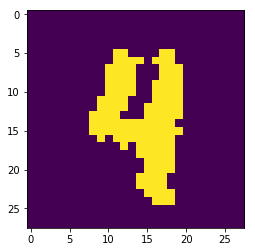

In [96]:
test = extend_input(x_train[0],loc, scale, n_parts)
plt.imshow(x_val[0].reshape(orig_dim))

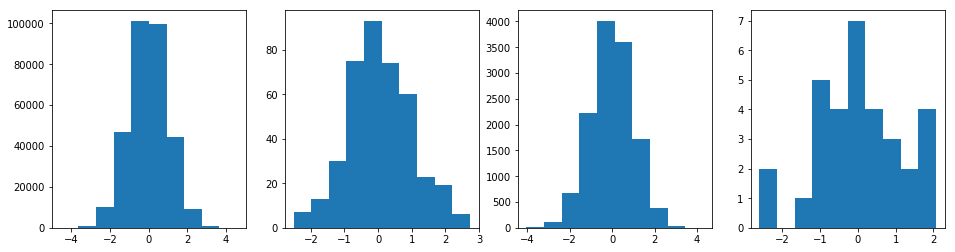

In [97]:
weights = encoder.model.get_weights()
fig,ax = plt.subplots(1,len(weights),figsize=(16,4))
for i,weight in enumerate(weights):
    ax[i].hist(weight.reshape(-1))

In [98]:
for layer in encoder.model.layers:
    activation = sess.run(layer.output,feed_dict={encoder.model.input:test})
    print(layer)
    print('activation mean:{}'.format(np.mean(activation)))
    print('activation std:{}'.format(np.std(activation)))

activation mean:0.055691346526145935
activation std:0.23676857352256775
activation mean:0.055691346526145935
activation std:0.23676857352256775
activation mean:0.043601009994745255
activation std:0.9383307695388794
activation mean:0.043601009994745255
activation std:0.9383307695388794
activation mean:1.262417197227478
activation std:19.754253387451172


In [99]:
z = encoder.model.predict(test,batch_size=n_parts)

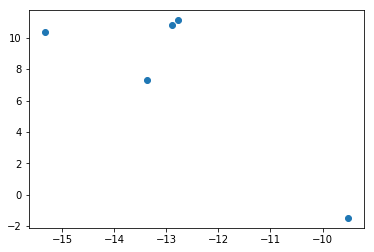

In [100]:
plt.scatter(z[:,0],z[:,1])
plt.show()

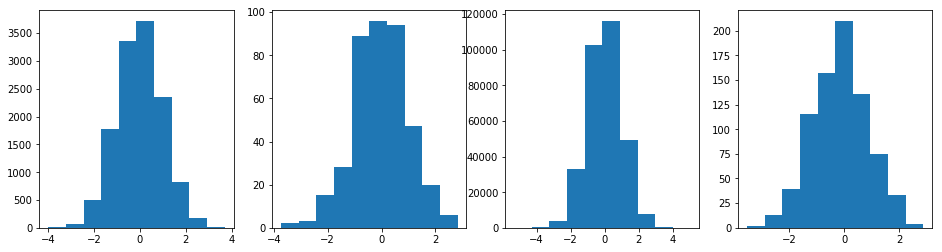

In [101]:
weights = decoder.model.get_weights()
fig,ax = plt.subplots(1,len(weights),figsize=(16,4))
for i,weight in enumerate(weights):
    ax[i].hist(weight.reshape(-1))

activation mean:1.262417197227478
activation std:19.754253387451172


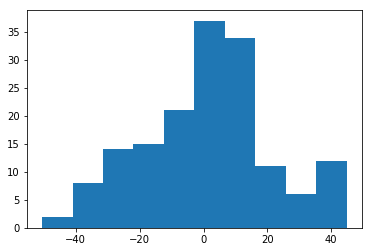

activation mean:-0.014983887784183025
activation std:0.9971465468406677


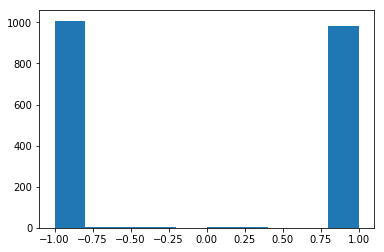

activation mean:-0.014983887784183025
activation std:0.9971465468406677


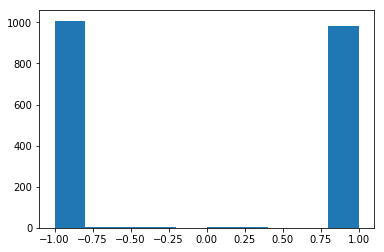

activation mean:0.13558028638362885
activation std:0.32339221239089966


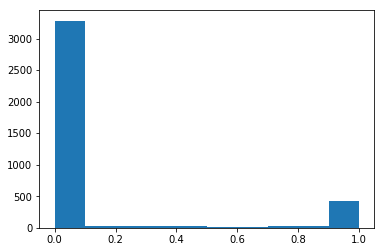

In [102]:
for layer in decoder.model.layers:
    activation = sess.run(layer.output,feed_dict={decoder.model.input:z})
    print(layer)
    print('activation mean:{}'.format(np.mean(activation)))
    print('activation std:{}'.format(np.std(activation)))
    plt.hist(activation.reshape(-1))
    plt.show()

In [103]:
prediction = decoder.model.predict(z)

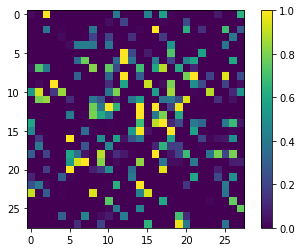

In [104]:
plt.imshow(np.mean(prediction,axis=0).reshape(orig_dim))
plt.colorbar()

In [105]:
x_rec = np.round(np.mean(prediction,axis=0))

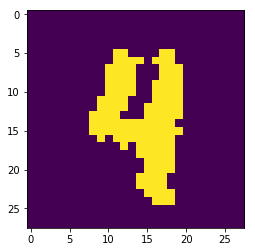

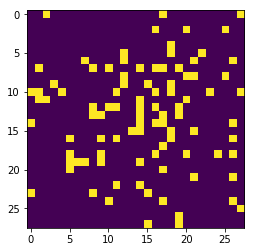

In [106]:
plt.imshow(x_val[0].reshape(28,28))
plt.show()
plt.imshow(x_rec.reshape(28,28))
plt.show()

In [33]:
#     def build_grad(self):
#         grads = []
#         for eta in self.model.trainable_weights:
#             a = []
#             for i in range(self.n_parts):
#                 b = []
#                 for j in range(self.output_dim):
#                     b.append(tf.gradients(self.model.output[i,j],eta))
#                 a.append(b)
#             grads.append(a)
#         return grads

#     eta_1 = []
#     for i,eta in enumerate(encoder.model.get_weights()):
#         a = np.array(eta_grad[i]).reshape(n_parts,latent_dim,-1)
#         b = np.array([np.matmul(phi[j,:].reshape(1,latent_dim),a[j,:,:]) for j in range(n_parts)])
        
#         eta_1.append(eta + epsilon * np.sum(b,axis=0).reshape(eta.shape))
#     encoder.model.set_weights(eta_1)

<tf.Tensor 'dense_2/BiasAdd:0' shape=(50, 32) dtype=float32>